## Projeto 6 - Classificação de imagens - Pytorch e Transfer Learning

        Let's Data - Jornada Cientista da Dados

**Motivação:** Estudar sobre utilização de redes pré-treinadas na classificação de imagens 

**Objeto de Estudo:** Na empresa fictícia Let's Veggie está com um problema na classificação dos produtos na loja. Muitos funcionarios não sabem diferenciar os vegetais e frutas, assim a empresa precisa de uma aplicação que faça essa classificação.

In [1]:
#!pip install torch torchvision pillow scikit-learn gradio

In [2]:
# Importando as bibliotecas 

from matplotlib import pyplot as plt
import numpy as np 
import os 
import PIL.Image #usamos para mostrar as imagens e ler elas 

import time 
import torch, torchvision 
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader # estrutura os dados para rede de treinamento 
import torch.nn as nn
import torch.optim as optim

In [3]:
# Separando as imagens em base de treino, validação e teste. Importante deixar uma pasta raw com os dados originais 

diretorio_base_imagens = "C:\\Users\\maria\\Projeto 6\\data\\data\\raw"

# 'os.listdir' - Retorna uma lista contendo os nomes dos arquivos no diretório.
pasta_com_os_nomes_de_vegetais = os.listdir(diretorio_base_imagens)
pasta_com_os_nomes_de_vegetais

['batata', 'cenoura', 'limao', 'tomate']

In [4]:
# Separando a basa em 80% treino, 10% validação, 10% teste. Vamos criar uma separação estratificada 

quantidade_por_label = {}
for pasta in pasta_com_os_nomes_de_vegetais:
    # 'os.path.join' - une um ou mais componentes de caminho de forma inteligente.
    # '(os.listdir(os.path.join(diretorio_base_imagens,pasta)' - lista todas as imagens que tem dentro da pasta 
    quantidade_por_label[pasta] = len(os.listdir(os.path.join(diretorio_base_imagens,pasta)))

quantidade_por_label

{'batata': 146, 'cenoura': 181, 'limao': 111, 'tomate': 107}

In [5]:
#Criando uma pasta de treino, validação e teste

diretorio_imagens_processadas = "C:\\Users\\maria\\Projeto 6\\data\\data\\processed"

dir_treino = os.path.join(diretorio_imagens_processadas, 'treino')
dir_validacao = os.path.join(diretorio_imagens_processadas, 'validacao')
dir_teste = os.path.join(diretorio_imagens_processadas, 'teste')

#verificando se as pastas foram criadas, senão foram 'os.makedirs' cria 

if not os.path.exists(dir_treino):
    os.makedirs(dir_treino)

if not os.path.exists(dir_validacao):
    os.makedirs(dir_validacao)
    
if not os.path.exists(dir_teste):
    os.makedirs(dir_teste)

In [6]:
# importando a biblioteca shutil para fazer copia de arquivo 

import shutil
from sklearn.model_selection import train_test_split

In [7]:
# Criando uma pasta para cada classe(batata, cenoura, limao, tomate) dentro de treino, validação e teste 

for classe in pasta_com_os_nomes_de_vegetais:
    
    dir_classe_treino = os.path.join(dir_treino, classe)
    dir_classe_validacao = os.path.join(dir_validacao, classe)
    dir_classe_teste = os.path.join(dir_teste, classe)
    
    if not os.path.exists(dir_classe_treino):
        os.makedirs(dir_classe_treino)
        
    if not os.path.exists(dir_classe_validacao):
        os.makedirs(dir_classe_validacao)
        
    if not os.path.exists(dir_classe_teste):
        os.makedirs(dir_classe_teste)
        
    # fazendo o caminho para a pasta com as imagens originais 
    pasta_classe = os.path.join(diretorio_base_imagens, classe)
    
    # listando todos os arquivos de imagem para essa clase 
    arquivos_classe = os.listdir(pasta_classe)
    
    # separando 80% treino e 20% validação/teste - Fazendo a separação em 80/20 pois 'train_test_split' separa apenas 2 
    # estamos passando uma lista com as imagens de cada classe, 'shuffle=True' ele vai embaralrar as imagens 
    treino, valid_test = train_test_split(arquivos_classe, shuffle=True, test_size=0.2, random_state=42)
    
    # Fazendo o 2 split no 'valid_test'. Agora o 'test_size' coloco 0.5 para divir em 50%
    validacao, teste = train_test_split(valid_test,shuffle=True,test_size=0.5,random_state=42)
    
    # Agora que tenho as variáveis de validação e teste não preciso mais da valid_test
    del valid_test
    
    print(f'{classe} - treino: {len(treino)} - validação: {len(validacao)} - teste: {len(teste)}')
    
    # Copiando os arquivos efetivamente para as pastas de treino, validação e teste 
    for imagem_treino in treino:
        caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_treino)
        caminho_destino = os.path.join(dir_classe_treino, imagem_treino)
        # estou pegando imagem por imagem caminho_origem (raw-'batata/tomante...'-imagem) e fazendo uma copia no 
        # caminho_destino (processed-treino-'batata/tomate...'-imagem)
        shutil.copy(caminho_origem, caminho_destino)
    
    
    for imagem_validacao in validacao:
        caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_validacao)
        caminho_destino = os.path.join(dir_classe_validacao, imagem_validacao)
       
        shutil.copy(caminho_origem, caminho_destino)
        
    
    for imagem_teste in teste:
        caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_teste)
        caminho_destino = os.path.join(dir_classe_teste, imagem_teste)
       
        shutil.copy(caminho_origem, caminho_destino)

batata - treino: 116 - validação: 15 - teste: 15
cenoura - treino: 144 - validação: 18 - teste: 19
limao - treino: 88 - validação: 11 - teste: 12
tomate - treino: 85 - validação: 11 - teste: 11


### Pré Processamento

In [8]:
# definido o tamanho da imagem para 100
imagem_size = 100 

# 'transforms' - transformando as imagens 
transformacao_de_imagem = {
    'treino': transforms.Compose([ # Compõe várias transformações juntas.
        transforms.Resize(size=[imagem_size, imagem_size]), # Redimensiona a imagem de entrada em tamanho especificado.100p/100
        transforms.ToTensor() # Converter um ``PIL Image`` ou ``numpy.ndarray`` para tensor.
     ]), 
    'validacao': transforms.Compose([
        transforms.Resize(size=[imagem_size, imagem_size]),
        transforms.ToTensor()
    ]),
    'teste': transforms.Compose([
        transforms.Resize(size=[imagem_size,imagem_size]),
        transforms.ToTensor()
    ])
}

Nessa transformação fizemos o redimensionamento das imagens e passamos para tensores Py Torch. Como não foi uma alteração significativa as mudanças vão ser feitas mas imagens de treinamento, validação e teste 

Caso tenha a necessidade de fazer mais alterações vamos fazer apenas no treino. Podemos fazer rotações, espelhamentos, crop randomicos... 

In [9]:
# Renomeando os nomes das pastas 

pasta_treino = dir_treino
pasta_validacao = dir_validacao
pasta_teste = dir_teste

pasta_treino,pasta_validacao, pasta_teste

('C:\\Users\\maria\\Projeto 6\\data\\data\\processed\\treino',
 'C:\\Users\\maria\\Projeto 6\\data\\data\\processed\\validacao',
 'C:\\Users\\maria\\Projeto 6\\data\\data\\processed\\teste')

**Preparação para o treinamento**

    Definido informações importantes para o modelo - Tamanho do batch, número de classes, datasets, dataloaders(organiza os dados para treinamento e validação para o treinamento da rede neural), otimizadores 

In [10]:
# Tamanho do batch (vamos treinar de 8 em 8 imagens)
tamanho_do_batch = 8 

#número de classes 
numero_classes = len(os.listdir(pasta_treino)) # vamos usar o len caso depois adicionarmos outra classe a variável atualiza 

In [11]:
# carregando as imagens usando o datasets do torchvision 

# 'ImageFolder' - Um carregador de dados genérico onde as imagens são organizadas dessa maneira por padrão
    # root= Caminho do diretório raiz
    # transform= Falo quais são as transfgormações que eu quero que sejam feitas 
data = {
    'treino': datasets.ImageFolder(root=pasta_treino, transform=transformacao_de_imagem['treino']),
    'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transformacao_de_imagem['validacao'])
}
data

{'treino': Dataset ImageFolder
     Number of datapoints: 433
     Root location: C:\Users\maria\Projeto 6\data\data\processed\treino
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 'validacao': Dataset ImageFolder
     Number of datapoints: 55
     Root location: C:\Users\maria\Projeto 6\data\data\processed\validacao
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            )}

In [12]:
# associando os indices com os nomes das classes 

# estamos fazendo um dict comprehension, onde o indice é a chave e o nome da classe é o valor 
indice_para_classes = {indice: classes for classes, indice in data['treino'].class_to_idx.items()}

indice_para_classes

{0: 'batata', 1: 'cenoura', 2: 'limao', 3: 'tomate'}

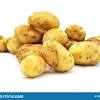

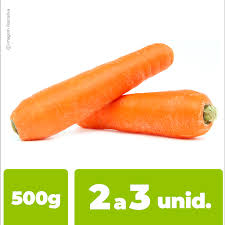

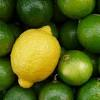

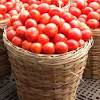

In [13]:
from IPython.display import Image 

# Mostrar algumas imagens
for classe in indice_para_classes.values():
    pasta_classe = os.path.join(pasta_treino, classe)
    arquivo_imagem = os.listdir(pasta_classe)[1]
    img = Image(filename=os.path.join(pasta_classe, arquivo_imagem))
    display(img)
    

In [14]:
# Quantidade de imagens para serem usadas para calcular o erro médio e a acurácia 

num_imagens_treino = len(data['treino'])
num_imagens_validacao = len(data['validacao'])

num_imagens_treino, num_imagens_validacao

(433, 55)

In [15]:
# Criando os DataLoader para o treino e validação 

data_loader_treino = DataLoader(data['treino'], batch_size=tamanho_do_batch,shuffle=True)
data_loader_validacao = DataLoader(data['validacao'], batch_size=tamanho_do_batch,shuffle=True)

### Transfer Learning 

Temos poucas imagens, dessa maneira fica dificil treinar um modelo de maneira eficiente. Assim vamos usar a Alexnet que tem milhares de imagem treinandas para ajudar nosso modelo. 

In [16]:
# Carregando Alexnet
# "weights=models.AlexNet_Weights.DEFAULT" falo que quero as imagens pré treinadas 

alexnet = models.alexnet(pretrained=True)

alexnet

C:\Users\maria\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Precisamos congelar os parametros da rede pré treinada, pois vou mudar a ultima camada para ele aprender as imagens que tenho salva, mas não quero que ele reaprenda todas as imgens que alexnet tem.  

In [17]:
# Precisamos congelar os parametros da rede pré-treinada 
# 'requires_grad' - desliga o treinamento e atualização dos pesos (coeficientes) das camadas da rede neural 

for param in alexnet.parameters():
    param.requires_grad = False

In [18]:
# alterando a ultima camada. Era - (6): Linear(in_features=4096, out_features=1000, bias=True)
# e vai ficar (6): Linear(in_features=4096, out_features=4, bias=True) 
# Lembrando que tenho 4 classes(tomate, batata, limão, cenoura)
alexnet.classifier[6] = nn.Linear(4096, numero_classes)

# Adicionando um novo modulo - 'LogSoftmax' converte efetivamente em probabilidade para facilitar nossa análise 
alexnet.classifier.add_module("7", nn.LogSoftmax(dim=1))

alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
#Confirmando que a camada 4 está congelada 
parametros_ultima_camada = alexnet.classifier[4].parameters()

[parametro for parametro in parametros_ultima_camada][0].requires_grad

False

In [20]:
# Vamos utilizar a função de erro de entropia cruzada (comum para problemas de classificação)

funcao_erro = nn.CrossEntropyLoss()

### Otimizador 

O otimizador é quem realmente muda os pesos de acordo com algoritmo - vamos usar Adam Optimizer 

In [21]:
otimizador = optim.Adam(alexnet.parameters())

otimizador

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [22]:
def treinar_e_validar(modelo, metrica_erro, otimizador, epocas=10):
    '''
    Função para treinamento e validação
    Parâmetros
        :param modelo: modelo para treinar e validar
        :param metrica_erro: critério de erro para minização
        :param otimizador: otimizador para alterar os parâmetros da rede
        :param epocas: número de épocas (default=10)
  
    Retorna
        melhor_modelo: modelo treinado com a melhor acurácia na validação
        historico: (dicionário): histórico com erro no treinamento, erro na validação e acurácia
    '''
    
    
    historico = []
    melhor_acuracia = 0.0
    melhor_modelo = None
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # 'cuda' - linguagem arquitetural de placa de video. Passando esse parametro vc pede para codigo
    # ser executado na placa de video (caso tenho uma placa compatível)e assim tem um desempenho melhor. 
    # Mas se não tiver placa compatível a CPU provavelmente vai dar conta do recado!    
   
    for epoca in range(epocas):
        # Cada época perpassa todas as imagens do treino e calcula erros de treino e validação
        # para aprendizado da rede neural
        
        inicio_epoca = time.time()
                
        # Erro e acertos de treino e validação nessa época. Cada época eu calculo o erro e o acerto 
        erro_treino = 0
        acertos_treino = 0
        erro_validacao = 0
        acertos_validacao = 0
        
        for i, (imagens_lote, y_reais) in enumerate(data_loader_treino):
            # Fazendo uma Iteração por batch. As entradas são os tensores do lote (batch)
            # 'data_loader_treino' traz as imagens e sua classificação('batata', 'cenoura'...)
                        
            # joga pra GPU ou CPU as imagens 
            imagens_lote = imagens_lote.to(device)
            y_reais = y_reais.to(device)
            
            # 'zero_grad()' - Define os gradientes de todos os :class:`torch.Tensor` otimizados para zero.
            otimizador.zero_grad()

            # Forward pass - calcular saídas a partir das entradas utilizando o modelo
            # Como o lote tem 8 imagens, teremos 8 previsões
            previsoes = modelo(imagens_lote)
                                       
            # Calcular erro das saidas que foram preditas com a classificação real 
            # e retorna a média dos 8 erros 
            erro = metrica_erro(previsoes, y_reais)
           
            # O backpropagation é a junção do erro.backward() + otimizador.step()
            # 'erro.backward()' - calcula os gradientes, ou seja, qual a direção dos coeficientes para reduzir o erro
            # Realizar o cálculo dos gradientes a partir do erro de predição
            erro.backward()
            
            # 'otimizador.step()' - Atualizar os parâmetros da rede de acordo com os gradientes calculados no backward
            # qual a direção deve atualizar os coeficientes da rede
            otimizador.step()
                                 
            # Calcular o erro total para esse lote (batch) e soma o erro no treino
            # O erro calculado já é a média dos 8 erros, portanto temos que multiplicar
            # pela quantidade de imagens do lote
            erro_treino += erro.item() * imagens_lote.size(0)
                       
            # 'torch.max' - retorna o valor da maior probabilidade e a posição. 
            # Como precisso apenas da posição coloco '_', pois não vou usar a info do maior valor
            # A posição, portanto, vai indicar a classe com maior probabilidade (0,1,2 e 3)
            _, classes_previstas = torch.max(previsoes.data, 1) # '1'-indica que quero na 2 dimesão
            
            #'classes_previstas == y_reais' é um bool 
            # 'type(torch.FloatTensor)' Transforma para float.Ex: True - 1, False - 0
            predicoes_corretas = (classes_previstas == y_reais).type(torch.FloatTensor)
            
            # Acurácia média do lote
            acertos = torch.mean(predicoes_corretas)
            
            # Calcular a acurácia total de treino do lote todo e adicionar a em acertos_treino
            acertos_treino += torch.sum(predicoes_corretas)
            
            
            
        # Validação - não é necessário rastrear os gradientes, pois o modelo não vai ser treinado com a validação
        # "desliga" o autograd. Vamos fazer só a previsão 
        
        with torch.no_grad():

            # Mudando de treino para validação
            modelo.eval()

            # Iteração de validação
            for j, (imagens_lote, y_reais) in enumerate(data_loader_validacao):
                imagens_lote = imagens_lote.to(device)
                y_reais = y_reais.to(device)

                # Forward pass de validação
                # Previsão do modelo treinado nessa época
                previsoes = modelo(imagens_lote)

                # Calcular erro de validação
                # Previsto versus os verdadeiros hortifruti
                erro = metrica_erro(previsoes, y_reais)

                # Calcular erro de validação e adicionar a valid_loss
                erro_validacao += erro.item() * imagens_lote.size(0)

                # Calcular a acurácia de validação
                _, classes_previstas = torch.max(previsoes.data, 1)
                predicoes_corretas = (classes_previstas == y_reais).type(torch.FloatTensor)

                # Converter os acertos para float e calcular a acurácia média
                acertos = torch.mean(predicoes_corretas)

                # Calcular a acurácia total de validação do lote todo e adicionar a em train_acc
                acertos_validacao += torch.sum(predicoes_corretas)

                       
        # Calcular a média de erro e acurácia no treino
        erro_medio_treino = erro_treino/num_imagens_treino
        acuracia_media_treino = acertos_treino/num_imagens_treino

        # Calcular a média de erro e acurácia na validação
        erro_medio_validacao = erro_validacao/num_imagens_validacao
        acuracia_media_validacao = acertos_validacao/num_imagens_validacao

        # Incluir no histórico os erros e acurácias méidas
        historico.append([erro_medio_treino, erro_medio_validacao, acuracia_media_treino, acuracia_media_validacao])
                
        fim_epoca = time.time()
    
        print(f"Época : {epoca+1:03d}, Treino: Erro: {erro_medio_treino:.4f}, Acurácia: {acuracia_media_treino*100:.4f}%, \n\t\tValidação : Erro : {erro_medio_validacao:.4f}, Acurácia: {acuracia_media_validacao*100:.4f}%, Tempo: {fim_epoca-inicio_epoca:.4f}s")
        
        # Testa se a acurácia na validação desse modelo nessa época é a melhor
        # Se for a melhor, salva no melhor modelo e na melhor acurácia
        if acuracia_media_validacao > melhor_acuracia:
            melhor_acuracia = acuracia_media_validacao
            melhor_modelo = modelo

    return melhor_modelo, historico

In [23]:
numero_epocas = 10 

modelo_treinado, historico = treinar_e_validar(alexnet, funcao_erro, otimizador, numero_epocas)

Época : 001, Treino: Erro: 0.3001, Acurácia: 89.3764%, 
		Validação : Erro : 0.0543, Acurácia: 98.1818%, Tempo: 9.0929s
Época : 002, Treino: Erro: 0.0397, Acurácia: 99.3072%, 
		Validação : Erro : 0.0358, Acurácia: 100.0000%, Tempo: 7.3090s
Época : 003, Treino: Erro: 0.0156, Acurácia: 99.5381%, 
		Validação : Erro : 0.0700, Acurácia: 98.1818%, Tempo: 7.3977s
Época : 004, Treino: Erro: 0.0095, Acurácia: 99.5381%, 
		Validação : Erro : 0.1075, Acurácia: 96.3636%, Tempo: 7.2418s
Época : 005, Treino: Erro: 0.0045, Acurácia: 100.0000%, 
		Validação : Erro : 0.0516, Acurácia: 98.1818%, Tempo: 7.3163s
Época : 006, Treino: Erro: 0.0099, Acurácia: 99.7691%, 
		Validação : Erro : 0.0588, Acurácia: 96.3636%, Tempo: 7.3516s
Época : 007, Treino: Erro: 0.0018, Acurácia: 100.0000%, 
		Validação : Erro : 0.0621, Acurácia: 96.3636%, Tempo: 7.3620s
Época : 008, Treino: Erro: 0.0012, Acurácia: 100.0000%, 
		Validação : Erro : 0.0563, Acurácia: 98.1818%, Tempo: 7.7237s
Época : 009, Treino: Erro: 0.0010, A

**Avaliando como foi a evolução de treino a cada época** 

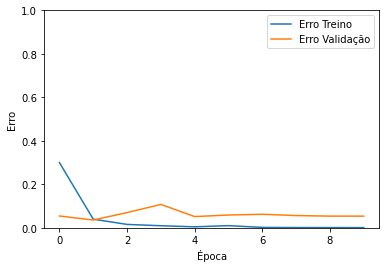

In [31]:
historico = np.array(historico)

plt.plot(historico[:,0:2]) 
plt.legend(["Erro Treino", "Erro Validação"])
plt.xlabel("Época")
plt.ylabel("Erro")
plt.ylim(0,1)
plt.show()

Percebemos que em cada época o erro vai diminuindo. Tem uma significativa redução da 2 época para a 3. 

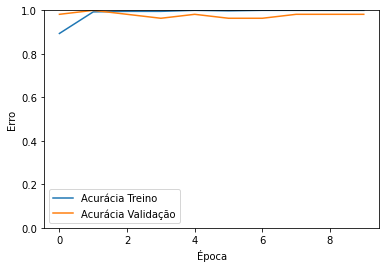

In [32]:
historico = np.array(historico)

plt.plot(historico[:,2:]) 
plt.legend(["Acurácia Treino", "Acurácia Validação"])
plt.xlabel("Época")
plt.ylabel("Erro")
plt.ylim(0,1)
plt.show()

Acurácia nas primeiras épocas no treinamento está um pouco a baixo do 100%, mas na 3 época em diante ela estabeliza. Já na validação tem pequenas mudanças, mas sempre proximo de 100% também 

### Criando a função de predição 

criando a função de predição da classe (batata,limão,cenoura,tomate) de uma imagem com o melhor modelo treinado. Mas agora não vamos atualizar gradientes. 

In [33]:
def predicao(imagem_teste):
    '''
    :param imagem_teste: imagem já transformada com o PIL 
    :return: um dict em que a chave vai ser o nome de classe: com o valor de predição. Essa informação para as 4 classes 
    '''
    #Buscando o transforms teste (Resize / ToTensor)
    transformacao = transformacao_de_imagem['teste']
    
    tensor_imagem_teste = transformacao(imagem_teste)  #transformando as imagens 
    
    tensor_imagem_teste = tensor_imagem_teste.view(1, 3, imagem_size, imagem_size)
    
    dict_predicao = dict()
    
    with torch.no_grad(): #Não precisamos calcular os gradientes 
        modelo_treinado.eval() 
        
        predicoes_log = modelo_treinado(tensor_imagem_teste) #Modelo retorna as probabilidades em log (log softmax)
        
        #'torch.exp' - uso para voltar a probabilidade de log para probabilidade linear 
        predicoes = torch.exp(predicoes_log)
        
        # A chave vai ser o nome de classe: com o valor de predição. Essa informação para as 4 classes 
        dict_predicao = {indice_para_classes[classe]: float(predicoes[0][classe]) for classe in range(numero_classes)}
        
    return dict_predicao

### Previsão em imagens de teste 


'batata'

'cenoura'

'limao'

'tomate'

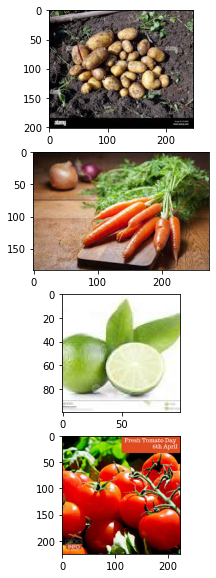

In [36]:
figura, plots = plt.subplots(nrows=numero_classes, ncols=1, figsize=(5,10)) # Crie uma figura e um conjunto de subtramas.

for indice, classe in enumerate(pasta_com_os_nomes_de_vegetais):
    pasta = os.path.join(pasta_teste, classe)
    imagem = os.path.join(pasta, os.listdir(pasta)[0])
    imagem_teste = PIL.Image.open(imagem)
    
    plots[indice].imshow(imagem_teste)
    
    predicoes = predicao(imagem_teste)
    
    display(max(predicoes, key=predicoes.get)) #mostra a classe que fez a predição 

**Criando a função que calcula a acuracia nas imagens na pasta de teste** 

In [41]:
def acuracia_teste(pasta_teste):
    acertos = 0
    total_imagem = 0
    
    for classe in os.listdir(pasta_teste):
        pasta_completa = os.path.join(pasta_teste,classe)
        total_imagem += len(os.listdir(pasta_completa))
        
        for imagem in os.listdir(pasta_completa):
            imagem = os.path.join(pasta_completa, imagem)
            imagem_teste = PIL.Image.open(imagem)
            predicoes = predicao(imagem_teste)
            resultado = max(predicoes, key=predicoes.get)
            
            if resultado == classe:
                acertos += 1 
                
    return 100* acertos/total_imagem

In [42]:
acuracia_teste(pasta_teste)

96.49122807017544

**A acuracia nas imagens de teste ficou em 96% um resultado um pouco abaixo da validação, mas teve um alto índice de acerto** 

### Deploy do Modelo 

Vamos usar o Gradio para fazer uma aplicação simples.

In [43]:
import gradio as gr

interface_gradio = gr.Interface(fn=predicao,inputs=gr.inputs.Image(type='pil'), outputs='label').launch(share=True)

C:\Users\maria\anaconda3\lib\site-packages\gradio\inputs.py:256: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://a2595547350ffa0e.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
